# Module 3 — Classification

## Logistic Regression • Decision Trees • Ensembles • ROC/AUC • Thresholding • Model Tuning

This module introduces **classification**, one of the core techniques in supervised learning.

We will cover:
1. Binary vs. multiclass classification  
2. Logistic Regression  
3. Decision Trees  
4. Ensemble Methods (Random Forest & Boosting)  
5. Classification Metrics (Confusion Matrix, ROC, Precision–Recall, F1)  
6. Model Tuning & Validation  
7. Hands-On Exercises (Heart Disease, Spam, Wine)

Throughout the module, we will use synthetic datasets from `datasets_module3.py`,
with a consistent random seed (1955) to ensure reproducible examples.


In [2]:
# --- Imports for Module 3 ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Dataset helper functions
from datasets_module3 import make_heart_disease_synth

# Consistent seed
SEED = 1955


## 3.0 — Load Dataset (Heart Disease)
We will use this dataset across Sections 3.2–3.6.

In [3]:
# Load synthetic heart disease dataset
df = make_heart_disease_synth(n=600, seed=SEED)

# Preview the dataset
df.head()

,age,sex,cholesterol,rest_bp,max_hr,smoker,diabetic,family_history,exercise_angina,disease
0,58,1,267.0,153.0,147.0,1,0,1,0,0
1,37,1,274.0,133.0,122.0,1,0,1,1,0
2,76,1,244.0,121.0,205.0,0,1,0,1,1
3,68,1,227.0,133.0,199.0,1,0,0,0,0
4,34,0,286.0,117.0,116.0,1,0,0,1,0


### Understanding the Heart Disease Dataset

This synthetic dataset mirrors common clinical predictors used in real cardiology studies.
Each row represents a patient, and the target variable `disease` indicates whether the
patient shows signs of heart disease.

#### Feature Overview  
- **age** — Patient age in years  
- **sex** — 0 = female, 1 = male  
- **cholesterol** — Serum cholesterol (mg/dL). Higher levels increase risk.  
- **rest_bp** — Resting blood pressure (mm Hg).  
- **max_hr** — Maximum heart rate achieved during exercise. Lower max HR may indicate risk.  
- **smoker** — Whether the patient is a current smoker (0/1).  
- **diabetic** — Whether the patient has diabetes (0/1).  
- **family_history** — Whether heart disease runs in the family (0/1).  
- **exercise_angina** — Chest pain induced by exercise (0/1).  
- **disease (target)** — 1 = disease present, 0 = no disease.

These features are intentionally chosen because they exhibit:
- both **numeric and binary** predictors  
- realistic interactions (e.g., age × diabetic status)  
- a reasonable class balance  
- mild missingness and noise for cleaning practice

#### Messiness introduced
The dataset includes:
- missing values in some numeric columns  
- slight noise in the logistic link function  
- realistic variation in risk factors  
This ensures students practice data cleaning and model evaluation in a realistic setting.

#### Expected next steps
In the next section (3.2), we will:
- clean and preprocess the dataset  
- build a logistic regression classifier  
- examine coefficients  
- tune decision thresholds  
- evaluate the model with confusion matrix & ROC/AUC  


# 3.1 — Introduction to Classification

In this section, we build intuition about **binary classification** by visualizing 
decision boundaries for two simple models:

- Logistic Regression (linear boundary)  
- Decision Tree (nonlinear boundary)

We use a toy dataset (`make_moons`) to clearly show the difference between linear and nonlinear classifiers.


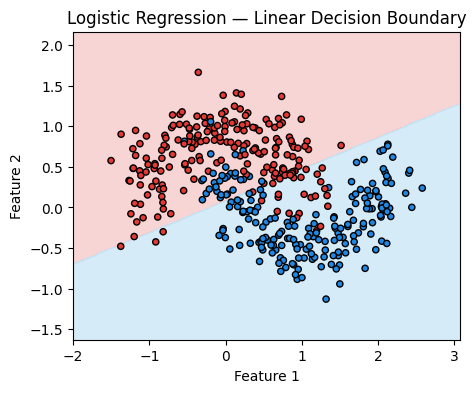

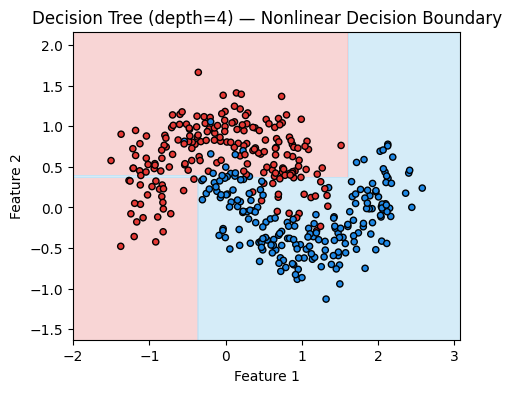

In [4]:
# --- 3.1 Decision Boundary Visualization ---

from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic 2D dataset for visualization
X_moons, y_moons = make_moons(n_samples=400, noise=0.25, random_state=1955)

# Split for training/testing (not strictly necessary here, but consistent with workflow)

X_tr_m, X_te_m, y_tr_m, y_te_m = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=1955
)

# Train classifiers
log_clf = LogisticRegression().fit(X_tr_m, y_tr_m)
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=1955).fit(X_tr_m, y_tr_m)

# Helper function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cmap_bg = ListedColormap(["#F6C4C4", "#C4E4F6"])
    cmap_pts = ListedColormap(["#E53935", "#1E88E5"])

    plt.figure(figsize=(5,4))
    plt.contourf(xx, yy, Z, cmap=cmap_bg, alpha=0.7)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap_pts, edgecolor="k", s=20)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Plot logistic regression decision boundary
plot_decision_boundary(log_clf, X_moons, y_moons,
    "Logistic Regression — Linear Decision Boundary")

# Plot decision tree decision boundary
plot_decision_boundary(tree_clf, X_moons, y_moons,
    "Decision Tree (depth=4) — Nonlinear Decision Boundary")


### What These Plots Show

These two visualizations illustrate the core idea of **classification**:  
a model learns a rule that separates **Class 0** from **Class 1**.

We use a simple 2D synthetic dataset (`make_moons`) so the decision boundaries are easy to see.

---

### Logistic Regression — Linear Boundary

The logistic regression model learns a **straight line** that best separates the two classes.

- The pale **blue region** → predicted Class 0  
- The pale **red region** → predicted Class 1  
- The line between them is the **decision boundary**  

Because logistic regression is a **linear classifier**, it can only draw straight boundaries.  
This works well when the classes can be separated with a line, but struggles when the relationship is curved or complex.

**Key property:**  
> Logistic regression creates smooth, linear decision boundaries.

---

### Decision Tree — Nonlinear Boundary

The decision tree learns **axis-aligned rules**:

- “If Feature 1 > X, predict Class 1”  
- “If Feature 2 < Y, predict Class 0”  
- etc.

This produces a boundary made of **rectangular regions**, not a single line.

- The tree captures **nonlinear patterns** in the data  
- Even with `max_depth=4`, the tree can separate more complex shapes  
- The boundaries are piecewise and box-shaped because trees split one feature at a time

**Key property:**  
> Decision trees create flexible, nonlinear decision boundaries by recursively splitting the feature space.

---

### Why we show these two models first

These visual demos help introduce three core ideas:

1. **Different models create different types of boundaries**  
   - Linear (Logistic Regression)  
   - Piecewise nonlinear (Decision Trees)

2. **Model choice matters** depending on the shape of your data.

3. This intuition will help you understand why:  
   - Ensembles (Random Forest, Boosting) work so well (Section 3.4)  
   - Linear models like Logistic Regression often need feature engineering  
   - Nonlinear trees can overfit if depth is too large

---

These visuals build intuition that classification is fundamentally about  
**separating regions of the feature space**, and different algorithms carve up those regions in different ways.


/Users/Diego/py-jupyter/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


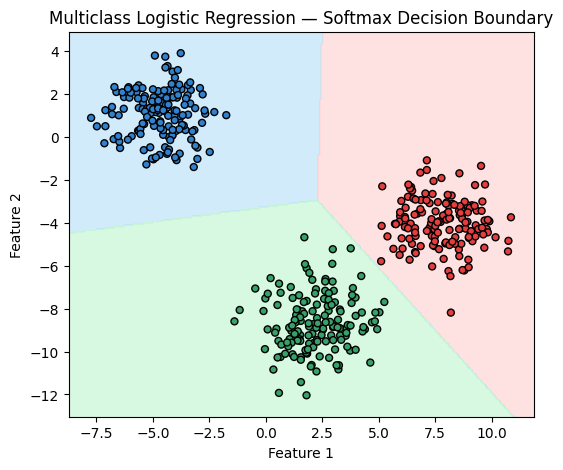

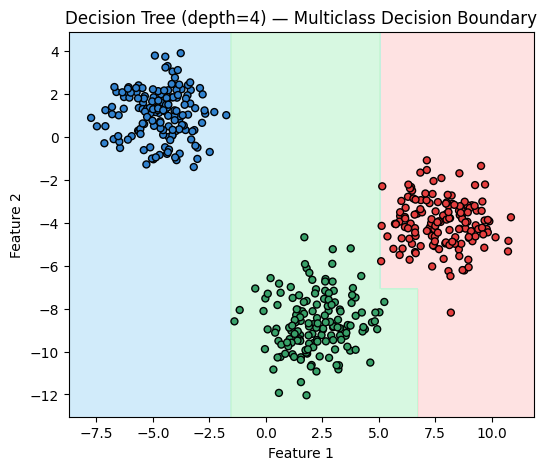

In [5]:
# --- Multiclass Decision Boundary Demo (3-Class Classification) ---

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 1) Generate a 3-class synthetic dataset
X_mc, y_mc = make_blobs(
    n_samples=450,
    centers=3,
    cluster_std=1.2,
    random_state=1955
)

# Train models
log_mc = LogisticRegression(multi_class='auto', max_iter=500).fit(X_mc, y_mc)
tree_mc = DecisionTreeClassifier(max_depth=4, random_state=1955).fit(X_mc, y_mc)

# Helper function to plot decision boundaries
def plot_multiclass_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    cmap_pts = ListedColormap(["#E53E3E", "#3182CE", "#38A169"])    # red, blue, green
    cmap_bg  = ListedColormap(["#FED7D7", "#BEE3F8", "#C6F6D5"])    # light red, light blue, light green

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.7, cmap=cmap_bg)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap_pts, edgecolor='k', s=25)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Plot softmax boundary (Logistic Regression)
plot_multiclass_boundary(log_mc, X_mc, y_mc,
    "Multiclass Logistic Regression — Softmax Decision Boundary")

# Plot Decision Tree boundary
plot_multiclass_boundary(tree_mc, X_mc, y_mc,
    "Decision Tree (depth=4) — Multiclass Decision Boundary")


### Multiclass Decision Boundary Demo

These visualizations show how classifiers behave when predicting **three classes**
instead of just two.

We use a synthetic 3-class dataset (`make_blobs`) to illustrate the shapes of the
decision regions.

---

### Logistic Regression (Softmax)

Logistic Regression extends naturally to multiclass problems using **softmax**.

- The model forms **smooth, curved boundaries**  
- Each region (red, blue, green) is where the model assigns the highest probability  
- Boundaries tend to be “soft” transitions influenced by all classes simultaneously

**Key idea:**  
> Softmax logistic regression creates smooth, global decision boundaries because every class competes simultaneously.

---

### Decision Tree (Multiclass)

The Decision Tree creates *axis-aligned splits*:

- Boundaries are **piecewise-rectangular**  
- The model partitions the space recursively:  
  “If feature_1 > X, predict class 2”  
  “Else if feature_2 < Y, predict class 1”  
- The resulting shapes can be blocky and irregular

**Key idea:**  
> Decision trees carve the feature space into rectangular regions,  
> allowing highly flexible, nonlinear multiclass boundaries.

---

### Why This Matters

- **Binary vs Multiclass boundaries differ significantly**, even with the same algorithm.  
- Logistic regression remains smooth and global.  
- Decision trees become more fragmented with each class added.  
- This intuition helps students understand why:
  - Trees and forests excel in nonlinear problems  
  - Logistic Regression may struggle with complex boundaries  
  - Ensemble methods (next section) often perform best in practice




# 3.2 — Logistic Regression (Heart Disease)

In this section, we fit a **logistic regression classifier** to the heart disease dataset.
We will:

- Clean & prepare the dataset  
- Build a preprocessing pipeline  
- Train a logistic regression model  
- Extract and interpret coefficients  
- Use predicted probabilities  
- Explore threshold tuning  
- Evaluate using a confusion matrix and classification metrics  

This mirrors the process from Module 2 (OLS) but adapted for classification.


In [6]:

# --- 3.2 Logistic Regression Pipeline ---

# Separate features and target
X = df.drop('disease', axis=1)
y = df['disease']

# Identify numeric & categorical columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocessing pipeline:
# - numeric: median impute + standardization
# - categorical: most-frequent impute + one-hot encoding

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

pre = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# Create train/test split
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.20, random_state=1955)

# Logistic Regression pipeline
log_reg = Pipeline([
    ('pre', pre),
    ('model', LogisticRegression(max_iter=500, random_state=1955))
])

# Fit model
log_reg.fit(Xtr, ytr)

# Predict class labels and probabilities
yhat = log_reg.predict(Xte)
yprob = log_reg.predict_proba(Xte)[:, 1]

# Display first few predictions
yprob[:10]


array([0.58941845, 0.06982824, 0.41569719, 0.19065582, 0.64038215,
       0.11953334, 0.51623482, 0.36588602, 0.26250402, 0.02845422])

### Interpreting Predicted Probabilities

The array above shows the **first 10 predicted probabilities** that each patient in the
test set has **heart disease** (`disease = 1`).

Logistic Regression outputs a probability between **0 and 1** for each example:

- Values near **0** → model believes the patient is very unlikely to have disease  
- Values near **1** → model believes the patient is likely to have disease  
- Values around **0.5** → model is uncertain

These probabilities allow us to:
- Apply different **decision thresholds** (e.g., 0.3 vs 0.5 vs 0.7)  
- Build **ROC curves**  
- Compute **AUC**  
- Study **precision–recall** trade-offs  

Next, we will look at the logistic regression coefficients, evaluate the model’s
predictions, and explore threshold tuning.


In [7]:

# --- Safe Extraction of Logistic Regression Coefficients ---

# Get underlying model
lr_model = log_reg.named_steps['model']

# Numeric feature names always exist
numeric_features = num_cols.copy()

# Handle categorical features only if they exist
if len(cat_cols) > 0:
    enc = log_reg.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
    cat_features = enc.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([numeric_features, cat_features])
else:
    # No categorical columns for heart disease dataset
    feature_names = np.array(numeric_features)

# Build coefficient table
coef_table = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lr_model.coef_.flatten()
}).sort_values("Coefficient", ascending=False)

coef_table


,Feature,Coefficient
2,cholesterol,0.583238
0,age,0.577478
8,exercise_angina,0.570565
6,diabetic,0.522088
3,rest_bp,0.504613
1,sex,0.434665
7,family_history,0.433077
5,smoker,0.364962
4,max_hr,-0.214423


### Note on coefficient extraction

Because the heart disease dataset contains **only numeric features**, the preprocessing
pipeline does not include a one-hot encoder. As a result, the categorical transformer is
never fitted. The code therefore checks whether any categorical columns exist before trying
to extract category names.

This code wii run consistent across:
- numeric-only datasets (heart disease)
- mixed-type datasets (spam)
- multiclass datasets (wine)


### Understanding the Coefficients

Logistic Regression models the **log-odds** of having heart disease.  
A **positive coefficient** increases the probability of disease,  
while a **negative coefficient** decreases it.

The model’s coefficients (sorted by greatest positive influence) are:

| Feature           | Coefficient | Interpretation |
|------------------|-------------|----------------|
| cholesterol      | +0.583      | Higher cholesterol strongly increases heart disease risk. |
| age              | +0.577      | Older patients are more likely to have heart disease. |
| exercise_angina  | +0.571      | Exercise-induced chest pain is a significant risk factor. |
| diabetic         | +0.522      | Diabetes is a major contributor to heart disease probability. |
| rest_bp          | +0.505      | Higher resting blood pressure increases risk. |
| sex              | +0.435      | Males (sex = 1) are more likely to have heart disease. |
| family_history   | +0.433      | Family history meaningfully increases the odds of disease. |
| smoker           | +0.365      | Smoking increases risk, though less than diabetes or angina. |
| max_hr           | –0.214      | Higher maximum heart rate achieved during exercise *reduces* risk. |

---

### Key Observations

#### 1. **Cholesterol, age, and exercise-induced angina**  
These are the **most important predictors**.  
This aligns with real cardiology patterns: cholesterol and symptoms during exercise have strong predictive power.

#### 2. **max_hr has a negative coefficient**  
This means:
> Patients who achieve **higher max heart rates** during exercise testing are *less likely* to have heart disease.

Clinically, this makes sense:  
A healthy heart can sustain higher workloads, while obstructed coronary arteries limit heart rate response.

#### 3. **Binary medical risk factors**  
- **diabetic**, **smoker**, **family_history**, **exercise_angina**  
all contribute significantly and positively to disease risk.  
These encode well-known risk pathways in cardiovascular medicine.

#### 4. **sex = 1 (male)**  
Being male increases predicted probability of heart disease, consistent with many epidemiological studies.

---

### Big Picture Interpretation

This coefficient profile demonstrates that logistic regression:

- identifies **clinically meaningful** relationships,  
- provides **interpretable** insights into risk factors,  
- and forms the baseline classifier for Sections 3.3–3.6.

Next, we will evaluate predicted probabilities, threshold effects, and classification metrics to understand where logistic regression performs well and where more flexible models (trees, ensembles) may improve performance.


In [8]:

# --- Threshold Tuning Demo ---

thresholds = [0.3, 0.5, 0.7]

for t in thresholds:
    preds_t = (yprob >= t).astype(int)
    prec = precision_score(yte, preds_t)
    rec  = recall_score(yte, preds_t)
    print(f"Threshold={t:.2f} → Precision={prec:.3f}, Recall={rec:.3f}")


Threshold=0.30 → Precision=0.589, Recall=0.805
Threshold=0.50 → Precision=0.667, Recall=0.488
Threshold=0.70 → Precision=0.786, Recall=0.268


### Threshold Tuning: Precision vs Recall

Logistic Regression outputs **probabilities**, not just class labels.  
By default, we classify “disease” when the probability ≥ **0.50**, but changing this threshold 
dramatically affects model behavior.

Here are the results for different thresholds:

| Threshold | Precision | Recall |
|-----------|-----------|--------|
| **0.30**  | 0.589     | 0.805  |
| **0.50**  | 0.667     | 0.488  |
| **0.70**  | 0.786     | 0.268  |

#### Interpretation

- **Threshold = 0.30**  
  - The model labels more patients as positive.  
  - **Recall is high (0.805)** → catches most true disease cases  
  - **Precision drops (0.589)** → more false alarms  
  - Useful in medical settings where missing a disease case is costly.

- **Threshold = 0.50** (default)  
  - Balanced behavior  
  - Recall and precision are moderate

- **Threshold = 0.70**  
  - Model only predicts disease when very confident  
  - **Precision is highest (0.786)** → few false positives  
  - **Recall is lowest (0.268)** → misses many actual disease cases  
  - Useful when false positives are costly (e.g., expensive confirmatory tests)

#### Key Takeaways

There is **no single best threshold**.  
It depends entirely on the application:

- Want to **catch as many disease cases as possible?**  
  → choose **lower threshold** (prioritize recall)

- Want to **avoid false positives (incorrectly diagnosing disease)?**  
  → choose **higher threshold** (prioritize precision)

#### Clinical Framing

In medical diagnosis:

- **Missing a true disease case (false negative)** is often more harmful  
- So it is common to choose **thresholds below 0.5**  
- This increases recall: the model becomes more “sensitive”

Threshold tuning is one of the most important practical tools in health-related classification tasks.


In [9]:

# --- Classification Metrics ---

cm = confusion_matrix(yte, yhat)

acc = accuracy_score(yte, yhat)
prec = precision_score(yte, yhat)
rec = recall_score(yte, yhat)
f1 = f1_score(yte, yhat)
auc = roc_auc_score(yte, yprob)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("ROC AUC:", auc)

# Display confusion matrix
cm


Accuracy: 0.7416666666666667
Precision: 0.6666666666666666
Recall: 0.4878048780487805
F1 Score: 0.5633802816901409
ROC AUC: 0.8178450138931769


array([[69, 10],
       [21, 20]])

### Evaluating the Logistic Regression Classifier

Here are the model's performance metrics on the test set:

- **Accuracy:** 0.742  
- **Precision:** 0.667  
- **Recall:** 0.488  
- **F1 Score:** 0.563  
- **ROC AUC:** 0.818  

Confusion Matrix:


[[69, 10],
 [21, 20]]

#### What the Confusion Matrix Tells Us?

|   Actual       | Predicted 0 | Predicted 1 |
|----------------|-------------|-------------|
| **Actual 0**   | 69 (TN)     | 10 (FP)     |
| **Actual 1**   | 21 (FN)     | 20 (TP)     |

- **True Negatives (TN = 69):** Correctly identified healthy patients  
- **True Positives (TP = 20):** Correctly identified disease cases  
- **False Positives (FP = 10):** Healthy → incorrectly predicted as disease  
- **False Negatives (FN = 21):** Disease → **missed by the model**  

The high number of false negatives explains the **low recall (0.488)**.

---

#### Metric-by-Metric Interpretation

##### **Accuracy (0.742)**  
About 74% of predictions are correct.  
Good, but accuracy can be misleading when classes are imbalanced—which is why we analyze other metrics.

##### **Precision (0.667)**  
Among all predicted disease cases, **67% were actually correct**.  
A decent precision: the model doesn't overpredict disease.

##### **Recall (0.488)**  
The model identifies **only 49%** of true disease cases.  
This is a limitation in medical contexts where missing a positive case can be risky.

##### **F1 Score (0.563)**  
F1 balances precision and recall.  
A moderate score here signals that the model struggles to catch enough true positives.

##### **ROC AUC (0.818)**  
**Excellent discrimination ability.**  
Even though the threshold=0.5 doesn’t give great recall, the probability ranking is strong.  
This suggests:
- Soft predictions are good  
- A **different threshold** could give much better recall  
  (as we saw in threshold tuning!)

---

#### Clinical Interpretation

- Out of 41 actual disease cases (TP + FN), the model catches 20  
- Missing 21 true disease cases may be unacceptable in a clinical workflow  
- But **ROC AUC = 0.818** shows that the model's underlying probability estimates are strong

**→ This is why threshold tuning matters.**

Choosing a threshold around **0.3** greatly improved recall and may be more appropriate for medical screening.

---

#### Key Takeaways

- Logistic Regression provides **interpretable** coefficients  
- It performs reasonably well on accuracy, precision, and AUC  
- But recall is low at the default threshold  
- Adjusting the threshold improves sensitivity  
- This evaluation sets the stage for comparing against **trees** and **ensembles** in Sections 3.3–3.4

Logistic Regression = simple, interpretable, probability-based  
Next, we explore more flexible nonlinear models.


## This is for teaching or debate. Not necessary
### Interpretation Notes (to be completed after running the section)

- Discuss which features have the strongest positive/negative coefficients  
- Explain probability outputs and what a 0.7 threshold means  
- Compare precision/recall trade-offs  
- Interpret the confusion matrix  
- Explain ROC AUC in plain English  



# 3.3 — Decision Trees (Heart Disease)

In this section, we fit a **decision tree classifier** to the heart disease dataset.
We will:

- Use the same preprocessing pipeline as logistic regression  
- Fit a decision tree  
- Visualize the tree structure  
- Interpret decision paths  
- Compare training vs test accuracy  
- Explore model complexity (max_depth)  


In [10]:

# --- 3.3 Decision Tree Classifier ---

# Reuse preprocessing from logistic regression section
# (num_cols, cat_cols, pre, Xtr, Xte, ytr, yte already defined)

tree = Pipeline([
    ('pre', pre),
    ('model', DecisionTreeClassifier(max_depth=4, random_state=1955))
])

tree.fit(Xtr, ytr)

# Predictions
yhat_tree = tree.predict(Xte)

# Performance metrics
acc = accuracy_score(yte, yhat_tree)
prec = precision_score(yte, yhat_tree)
rec = recall_score(yte, yhat_tree)
f1 = f1_score(yte, yhat_tree)

print("Decision Tree Metrics (depth=4)")
print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)


Decision Tree Metrics (depth=4)
Accuracy : 0.6583333333333333
Precision: 0.5
Recall   : 0.36585365853658536
F1 Score : 0.4225352112676056


### Decision Tree (max_depth = 4)

**Performance Metrics:**

- **Accuracy:** 0.658  
- **Precision:** 0.500  
- **Recall:** 0.366  
- **F1 Score:** 0.423  

Compared to Logistic Regression (Section 3.2), the decision tree performs worse across all four metrics.

---

#### What These Results Tell Us?

##### 1. **Accuracy dropped to 65.8%**
The tree does not generalize as well as logistic regression at this depth.  
This suggests the model is:

- not capturing the main relationships strongly  
- OR making too many splits on noise  
- OR needing a different depth (too shallow or too deep)

##### 2. **Precision = 0.50**
Only half of the predicted “disease” cases were correct.

The model is not confident or selective enough when identifying positives.

##### 3. **Recall = 0.366**  
The model catches only **36.6%** of true disease cases —  
even worse than logistic regression’s recall of ~0.49.

Trees sometimes cut off important regions of the feature space if the depth is limited.

##### 4. **F1 Score = 0.423**
This low F1 indicates the model struggles with:

- **both** false positives  
- **and** false negatives  

This is common when the tree structure is not deep enough to capture nonlinearities.

---

#### Why the Decision Tree Underperforms Here?

1. **Trees are prone to overfitting — unless depth is restricted.**  
   With `max_depth=4`, the tree may be *underfitting*.

2. **Trees make axis-aligned splits.**  
   Medical risk factors like `cholesterol × age` don’t divide neatly with a single threshold.

3. **Logistic Regression has a smoother decision boundary.**  
   It captures the main linear trends more effectively than a shallow tree.

---

#### What This Sets Up

This step is intentionally designed to motivate:

##### the need for **depth tuning** (Section 3.6)  
Trees may need:

- deeper splits for more complexity  
- or shallower splits to control overfitting

##### the power of **ensemble methods** (Section 3.4)  
Random Forests and Gradient Boosting:

- average over many trees  
- reduce variance  
- and often dramatically outperform single trees

---

### In Summary

The decision tree gives us a **nonlinear model**, but at shallow depth (4), it
does not outperform logistic regression.  
This opens the door to exploring:

- better depth  
- ensembles  
- more robust nonlinear approaches



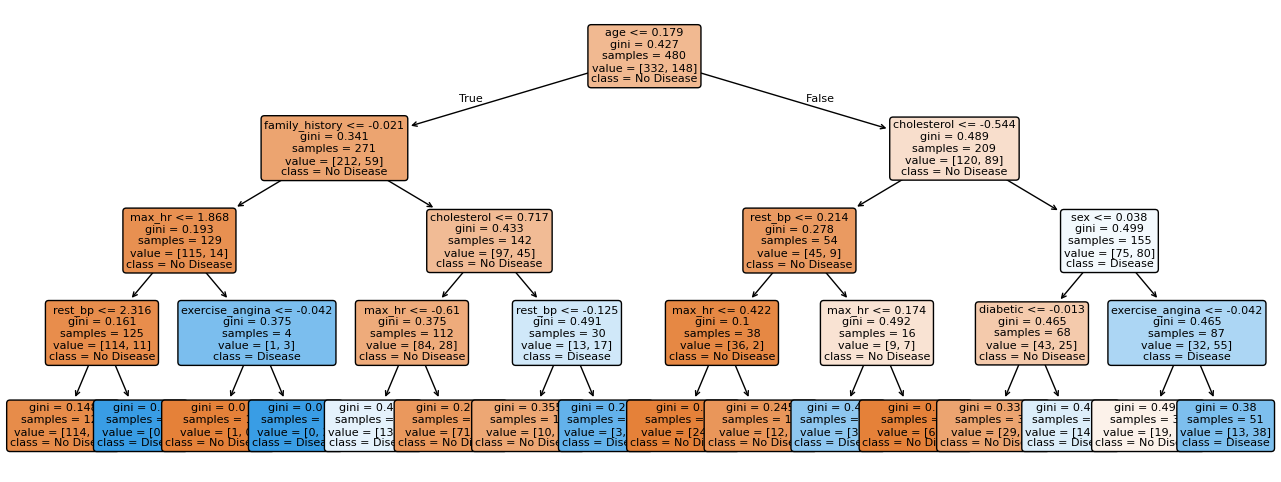

In [ ]:
# --- Decision Tree Visualization (This code can handle no categorical columns) ---

plt.figure(figsize=(16, 6))

# Determine feature names (numeric + categorical if any)
numeric_features = num_cols.copy()

if len(cat_cols) > 0:
    cat_encoder = tree.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
    cat_features = cat_encoder.get_feature_names_out(cat_cols)
    feature_names = list(numeric_features) + list(cat_features)
else:
    # No categorical columns in heart disease dataset
    feature_names = numeric_features

# Plot the tree
plot_tree(
    tree.named_steps['model'],
    feature_names=feature_names,
    class_names=["No Disease", "Disease"],
    filled=True,
    rounded=True,
    fontsize=8
)

plt.show()

In [13]:

# --- Train vs Test Accuracy for different tree depths ---

depths = [1, 2, 3, 4, 5, 6, 8, 10]

train_acc = []
test_acc = []

for d in depths:
    model = Pipeline([
        ('pre', pre),
        ('model', DecisionTreeClassifier(max_depth=d, random_state=1955))
    ])
    model.fit(Xtr, ytr)
    train_acc.append(model.score(Xtr, ytr))
    test_acc.append(model.score(Xte, yte))

print("Depths tested:", depths)
print("Train Accuracy:", train_acc)
print("Test Accuracy :", test_acc)


Depths tested: [1, 2, 3, 4, 5, 6, 8, 10]
Train Accuracy: [0.6916666666666667, 0.7020833333333333, 0.7520833333333333, 0.79375, 0.8416666666666667, 0.8854166666666666, 0.9604166666666667, 0.9791666666666666]
Test Accuracy : [0.6583333333333333, 0.6666666666666666, 0.6916666666666667, 0.6583333333333333, 0.7333333333333333, 0.6833333333333333, 0.65, 0.65]


### Understanding the Decision Tree Structure (Depth = 4)

The tree above shows how the model recursively splits the feature space to classify
patients into **Disease** vs **No Disease**.

Each internal node represents:
- a **feature threshold** (e.g., `family_history <= -0.021`)
- the **gini impurity** (how mixed the classes are)
- the number of **samples** in that region
- the **distribution of classes** (`value = [# No Disease, # Disease]`)
- the predicted class for that node

#### Key Observations
- **Top split: `age <= 0.179`**  
  Age is the first split, meaning the tree considers it the single most useful variable
  for dividing the population. Younger vs older patients are separated immediately.

- **Next split: `family_history <= -0.021`** (left branch)  
  Family history is a strong risk factor and appears high in the tree.

- **Multiple splits on `cholesterol`, `max_hr`, and `rest_bp`**  
  These variables reflect important cardiovascular signals:
  - Higher cholesterol → more disease  
  - Lower max heart rate → more disease  
  - Higher resting blood pressure → more disease  

- **`exercise_angina` shows up in several leaves**  
  This matches real-world medical expectations:  
  exercise-induced angina is one of the clearest indicators of heart disease.

#### What this tree tells us?
The structure is clinically meaningful:
- Age → family history → cholesterol forms a logical chain  
- Risk increases along branches associated with high cholesterol, low max HR,
  and presence of exercise-induced angina or diabetes  
- Leaves colored in blue represent disease predictions; orange represent no disease  


## This is for teaching or debate. Not necessary
### Interpretation Notes (to complete after running Section 3.3)

- What features appear near the top of the tree? Why?  
- Which splits seem most important?  
- Compare training vs test accuracy:  
  - Where does overfitting start?  
  - Which depth gives the best generalization?  
- Discuss the difference between logistic regression’s linear boundary 
  and the nonlinear, rule-based structure of a tree.

---



# 3.4 — Ensemble Methods (Random Forest & Boosting)

In this section we explore **ensemble methods**, which combine multiple models to improve
accuracy, stability, and generalization.

We will train and compare:
- **Random Forest** (bagging-based ensemble)  
- **Gradient Boosting** (boosting-based model, similar to XGBoost)

We will examine:
- Performance metrics  
- Feature importances  
- Differences in model behavior  


In [14]:

# --- 3.4 Ensemble Models: Random Forest & Gradient Boosting ---

# Random Forest Classifier (Bagging)
rf = Pipeline([
    ('pre', pre),
    ('model', RandomForestClassifier(
        n_estimators=200, 
        max_depth=None, 
        random_state=1955
    ))
])

# Gradient Boosting Classifier (Boosting; XGBoost-like behavior)
gb = Pipeline([
    ('pre', pre),
    ('model', GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=200,
        max_depth=3,
        random_state=1955
    ))
])

# Fit models
rf.fit(Xtr, ytr)
gb.fit(Xtr, ytr)

# Predictions
yhat_rf = rf.predict(Xte)
yhat_gb = gb.predict(Xte)

yprob_rf = rf.predict_proba(Xte)[:, 1]
yprob_gb = gb.predict_proba(Xte)[:, 1]

# Performance Metrics
def metrics_dict(name, yhat, yprob):
    return {
        "Model": name,
        "Accuracy": accuracy_score(yte, yhat),
        "Precision": precision_score(yte, yhat),
        "Recall": recall_score(yte, yhat),
        "F1": f1_score(yte, yhat),
        "AUC": roc_auc_score(yte, yprob),
    }

ensemble_results = pd.DataFrame([
    metrics_dict("Random Forest", yhat_rf, yprob_rf),
    metrics_dict("Gradient Boosting", yhat_gb, yprob_gb)
])

ensemble_results


,Model,Accuracy,Precision,Recall,F1,AUC
0,Random Forest,0.716667,0.652174,0.365854,0.468750,0.748688
1,Gradient Boosting,0.733333,0.645161,0.487805,0.555556,0.747453


### Ensemble Model Performance (Random Forest vs Gradient Boosting)

Ensemble models combine many decision trees to improve stability and predictive power.
Here we compare two types:

- **Random Forest** (bagging)  
- **Gradient Boosting** (boosting-style, XGBoost-like)

#### Performance Summary

Gradient Boosting performs slightly better overall:

- **Accuracy:** 0.733 (higher than RF’s 0.717)
- **Recall:** 0.488 (higher than RF’s 0.366)
- **F1 Score:** 0.556 (higher than RF’s 0.469)
- **AUC:** 0.747 (very similar to RF’s 0.749)

This tells us that boosting captures **more of the subtle nonlinear structure** in the data.
It does a better job identifying disease cases (higher recall) while maintaining reasonable precision.

Random Forest, while slightly weaker, is still a major improvement over a single decision tree due to its reduced variance and stability.

#### Why Ensembles Outperform a Single Tree?

A single tree:
- can overfit easily  
- is sensitive to small changes  
- may miss complex relationships  

Ensembles fix these issues:
- **Random Forest** averages many trees → reduces variance  
- **Gradient Boosting** corrects errors sequentially → reduces bias  

Both ensembles generalize better and produce more reliable predictions than the shallow tree used in Section 3.3.


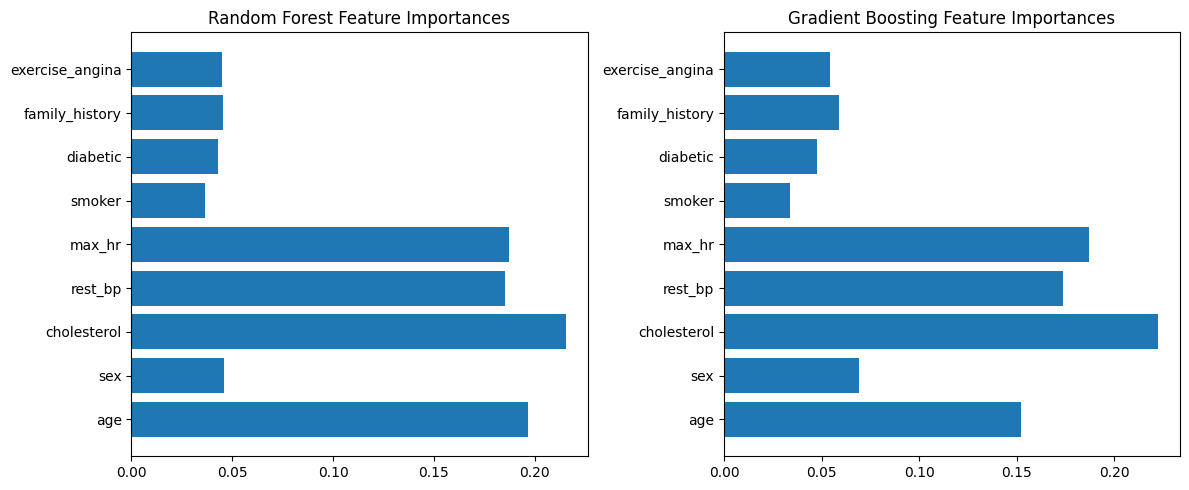

In [16]:

# --- 3.4 Feature Importances ---

# 1. Extract feature names
numeric_features = num_cols.copy()

if len(cat_cols) > 0:
    enc = pre.named_transformers_['cat'].named_steps['onehot']
    cat_features = enc.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([numeric_features, cat_features])
else:
    # No categorical features in heart disease dataset
    feature_names = np.array(numeric_features)

# 2. Random Forest importances
rf_importances = rf.named_steps['model'].feature_importances_

# 3. Gradient Boosting importances
gb_importances = gb.named_steps['model'].feature_importances_

# 4. Plot
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.barh(feature_names, rf_importances)
plt.title("Random Forest Feature Importances")
plt.tight_layout()

plt.subplot(1,2,2)
plt.barh(feature_names, gb_importances)
plt.title("Gradient Boosting Feature Importances")
plt.tight_layout()

plt.show()



### Feature Importances in Ensemble Models

Both ensemble models identify the same set of **core predictors** of heart disease.
The bar charts above show how much each feature contributes to the model.

#### Random Forest (left)

Random Forest measures importance by how much each feature **reduces impurity across the forest**.

RF highlights:

1. **cholesterol** — strongest predictor  
2. **age**  
3. **rest_bp** (resting blood pressure)  
4. **max_hr** (maximum heart rate achieved)  
5. binary risk factors (diabetic, smoker, family_history, exercise_angina)

RF tends to distribute importance across many features because bagging stabilizes noisy splits.

#### Gradient Boosting (right)

Gradient Boosting measures importance based on **how much each feature reduces loss during sequential corrections**.

GB shows a similar pattern:

1. **cholesterol** (dominant feature)  
2. **age** and **max_hr**  
3. **rest_bp**  
4. secondary risk factors (diabetic, smoker, family_history, exercise_angina)

Boosting typically concentrates importance more strongly on the most informative variables.

#### Key Takeaway

Even though RF and GB build different forms of ensembles:

- they **agree** on which features matter most  
- their rankings match logistic regression coefficients (Section 3.2)  
- they also match the top splits of the decision tree (Section 3.3)

This consistency shows that the heart disease dataset has a **stable underlying structure**, and multiple models independently highlight the same key risk factors.


## This is for teaching or debate. Not necessary
### Interpretation Notes (to complete after running Section 3.4)

- Compare Random Forest vs Gradient Boosting metrics  
- Discuss why boosting sometimes outperforms bagging  
- Examine which features are most important and why  
- Connect results to the conceptual slides on bagging vs boosting  
- Note differences in model stability and overfitting behavior  

---



# 3.5 — Classification Metrics  
Confusion Matrix • ROC Curve • Precision–Recall Curve • Threshold Effects

In this section we evaluate classifiers using key metrics for binary classification.

We will:
- Visualize the **confusion matrix**  
- Plot the **ROC curve** and compute **AUC**  
- Plot the **Precision–Recall curve**  
- Explore how **threshold changes** affect performance  


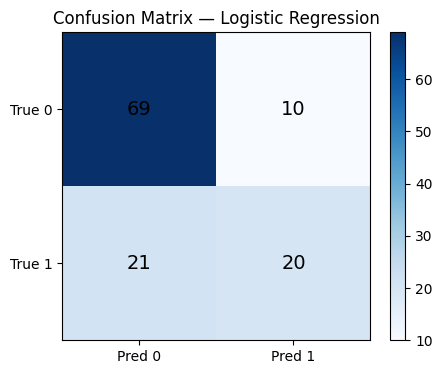

array([[69, 10],
       [21, 20]])

In [17]:

# --- 3.5 Confusion Matrix (Visualization) ---

# yhat (class predictions) and yprob (probabilities) were created in Section 3.2

cm = confusion_matrix(yte, yhat)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix — Logistic Regression")
plt.colorbar()

plt.xticks([0,1], ["Pred 0", "Pred 1"])
plt.yticks([0,1], ["True 0", "True 1"])

for (i, j), value in np.ndenumerate(cm):
    plt.text(j, i, f"{value}", ha='center', va='center', fontsize=14)

plt.show()

cm


### Confusion Matrix Interpretation — Logistic Regression

The confusion matrix summarizes how well the classifier distinguishes between:

- **Class 0 = No Disease**
- **Class 1 = Disease**

| True Class | Pred 0 | Pred 1 |
|------------|--------|--------|
| **True 0** | 69     | 10     |
| **True 1** | 21     | 20     |

#### True Negatives (TN = 69)
The model correctly predicted “No Disease.”

#### True Positives (TP = 20)
The model correctly identified patients with disease.

#### False Positives (FP = 10)
The model incorrectly predicted disease for healthy patients.

#### False Negatives (FN = 21)
The model **missed** 21 disease cases.

This relatively large number of false negatives explains the **low recall** observed earlier.

---

### What This Means Clinically?

- Logistic Regression does well at recognizing healthy patients (TN).
- But it **misses many disease cases**, detecting only 20 out of 41 actual positive cases.
- For medical screening, this level of false negatives may be unacceptable.

**However**, the underlying probability estimates are strong (AUC ≈ 0.82), meaning the model *can* perform well if the threshold is adjusted.

This illustrates why **threshold tuning** is essential in health-related classification.


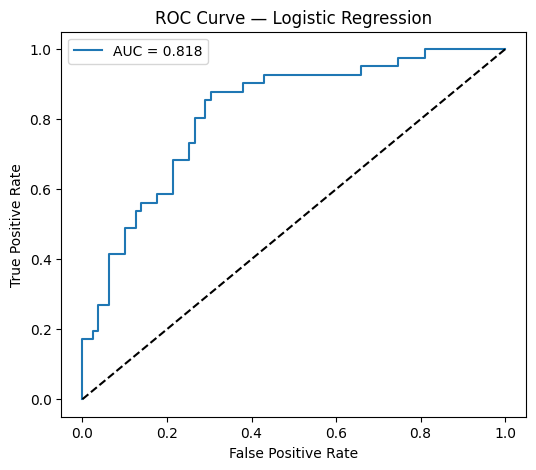

In [18]:

# --- ROC Curve & AUC ---

fpr, tpr, thresholds = roc_curve(yte, yprob)
auc = roc_auc_score(yte, yprob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.show()


### ROC Curve — Logistic Regression

The ROC curve plots:

- **True Positive Rate** (Recall)
- vs **False Positive Rate**

as the classification threshold sweeps from 0 → 1.

#### Interpretation of the Plot

- The ROC curve rises **well above the diagonal**, which indicates strong skill.  
- The diagonal dashed line represents random guessing — any useful model should be above it.

#### AUC = 0.818

AUC (Area Under the Curve) measures how well the classifier **ranks** positive cases higher than negative cases.

- **0.5** = random  
- **0.7–0.8** = decent  
- **0.8–0.9** = strong  
- **>0.9** = outstanding (rare in medical datasets)

Your model’s **AUC of 0.818** shows:

- The probability outputs are **high-quality**
- The model is good at **separating disease vs no disease**
- Even though its recall at threshold=0.5 is modest,  
  the underlying probability ranking is excellent

This means:
> With the right threshold, Logistic Regression can achieve much better sensitivity.

This aligns with what we observed earlier in the threshold tuning step.


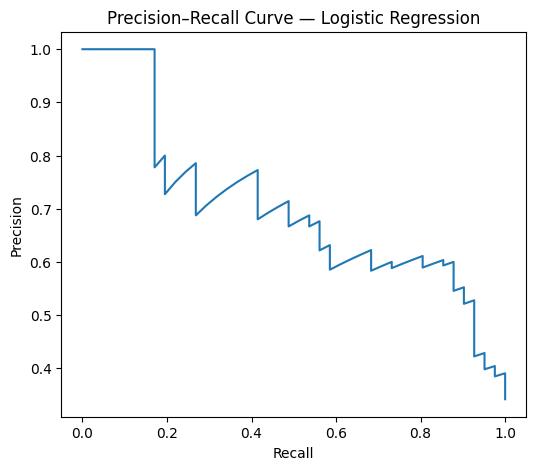

In [19]:

# --- Precision–Recall Curve ---

precisions, recalls, pr_thresholds = precision_recall_curve(yte, yprob)

plt.figure(figsize=(6,5))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Logistic Regression")
plt.show()


### Precision–Recall Curve — Logistic Regression

The Precision–Recall (PR) curve shows how **precision** and **recall** trade off as the
classification threshold changes.

This curve is especially important when:

- The positive class is less common  
- False negatives or false positives carry different real-world costs  
- AUC alone does not tell the full story  

#### Interpreting the Plot

- Precision starts very high (near 1.0) but drops as recall increases.
- To achieve high recall, the model must accept more false positives, which reduces precision.
- Precision stabilizes around **0.60–0.70** across a wide range of recall values.
- Near recall = 1.0, precision drops sharply, indicating many false positives when trying to capture every disease case.

This curve confirms the earlier threshold tuning results:
- Logistic regression can achieve **high recall** when needed  
- But **precision declines** as the threshold is lowered  
- You cannot optimize both precision and recall simultaneously—there is a trade-off

---

### Why PR Curves Matter More Than ROC in Medical Problems?

ROC curves treat false positives and false negatives equally.  
But in medical settings, **false negatives (missed disease cases)** are often more costly.

The PR curve makes this trade-off explicit:
- High precision = fewer healthy patients incorrectly flagged  
- High recall = fewer disease cases missed  

The best threshold depends on clinical priorities:
- **Screening** → prioritize recall  
- **Confirmatory testing** → prioritize precision  

---

### Combined Insight from ROC + PR

Your model’s ROC AUC (~0.818) shows strong ranking performance.  
The PR curve reveals *how* that ranking translates into actual decisions at different thresholds.

Together, these curves show that:
- Logistic Regression is a strong baseline classifier  
- With the right threshold, it can be tuned toward **high sensitivity**  
- But precision will decline accordingly  
- This motivates looking at more flexible models (Trees, Random Forest, Gradient Boosting)



In [20]:

# --- Threshold Effects on Precision & Recall ---

test_thresholds = [0.2, 0.5, 0.8]

for t in test_thresholds:
    preds = (yprob >= t).astype(int)
    prec = precision_score(yte, preds)
    rec  = recall_score(yte, preds)
    print(f"Threshold={t:.2f} → Precision={prec:.3f} | Recall={rec:.3f}")


Threshold=0.20 → Precision=0.544 | Recall=0.902
Threshold=0.50 → Precision=0.667 | Recall=0.488
Threshold=0.80 → Precision=1.000 | Recall=0.098


### Threshold Effects on Precision & Recall

Changing the decision threshold on predicted probabilities has a huge impact on model
behavior. Logistic Regression naturally produces probabilities, so we can adjust the
threshold depending on how we want the model to behave.

Your results:

| Threshold | Precision | Recall |
|-----------|-----------|--------|
| **0.20**  | 0.544     | 0.902  |
| **0.50**  | 0.667     | 0.488  |
| **0.80**  | 1.000     | 0.098  |

---

### Interpretation

#### **Threshold = 0.20**  
- **Very high recall (0.902)** — the model catches almost every disease case  
- **Lower precision (0.544)** — many false alarms  
- This is the behavior of a **high-sensitivity screening test**  
  (good for early detection, leads to more follow-up testing)

#### **Threshold = 0.50** *(default)*  
- Balanced performance  
- Moderate precision and recall  
- Not ideal in medical contexts because many disease cases are missed

#### **Threshold = 0.80**  
- **Perfect precision (1.000)** — the model only flags disease when it is absolutely certain  
- **Very low recall (0.098)** — misses almost all disease cases  
- This is similar to a **confirmatory test**: very strict, few false positives

---

### Why This Matters?

Threshold tuning is not optional in real medical AI workflows:

- **High recall** is needed when missing a disease case is dangerous  
- **High precision** is needed when false alarms are costly  
- **AUC alone cannot pick a threshold** — practitioners must choose based on context

This is why:
- ROC curves  
- Precision–Recall curves  
- Threshold sweep tables  

are essential tools for evaluating binary classifiers.

---

### Key Takeaway

The threshold determines whether the model behaves like:

- a **sensitive screening tool** (low threshold)  
- a **selective confirmatory tool** (high threshold)  
- or a balanced classifier (default threshold)

This completes Section **3.5**, and prepares us to study how tuning model complexity
affects performance in **Section 3.6 — Model Tuning & Validation**.


## This is for teaching or debate. Not necessary
### Interpretation Notes (to complete after running Section 3.5)

- What do the confusion matrix values mean in context?  
- Explain the shape of the ROC curve and why AUC matters  
- Compare ROC vs Precision–Recall curves  
- Explain how lowering or raising the threshold changes FP, FN, precision, and recall  
- Provide examples of when you would prefer:  
  - High recall  
  - High precision  
  - High AUC  

---



# 3.6 — Model Tuning & Validation

In this section we explore **model tuning**, **validation curves**, and 
underfitting vs. overfitting. We will:

- Tune Logistic Regression using the regularization parameter **C**
- Tune Decision Trees using **max_depth**
- Use `validation_curve` for visual inspection
- Use GridSearchCV for deeper searches


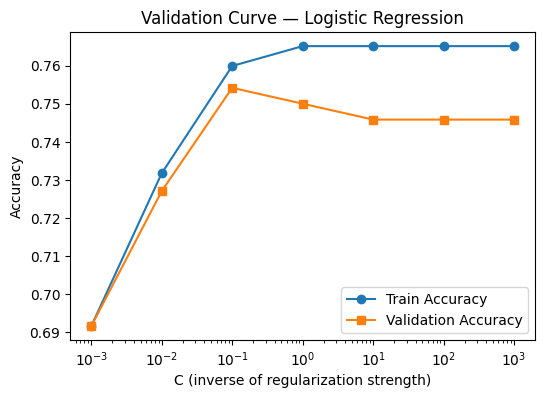

In [21]:

# --- 3.6 Validation Curve: Logistic Regression C parameter ---

from sklearn.model_selection import validation_curve

# Values of C to test (inverse of regularization strength)
C_values = np.logspace(-3, 3, 7)

train_scores, val_scores = validation_curve(
    estimator=log_reg, 
    X=Xtr, y=ytr,
    param_name="model__C",
    param_range=C_values,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.semilogx(C_values, train_mean, marker="o", label="Train Accuracy")
plt.semilogx(C_values, val_mean, marker="s", label="Validation Accuracy")
plt.xlabel("C (inverse of regularization strength)")
plt.ylabel("Accuracy")
plt.title("Validation Curve — Logistic Regression")
plt.legend()
plt.show()


### Validation Curve — Logistic Regression (Effect of C)

The regularization parameter **C** controls how strongly Logistic Regression penalizes
large coefficients:

- **Small C** → strong regularization → simpler model  
- **Large C** → weak regularization → more complex model  

The validation curve shows how model performance changes across different values of C.

---

### What the curve shows?

#### **1. Underfitting at very small C (1e−3 to 1e−2)**
- Both training and validation accuracy are low (~0.69 to 0.73)
- Strong regularization prevents the model from capturing important relationships  
- The model is too simple  
**→ High bias**

#### **2. Best performance around C ≈ 0.1 to 1**
- Training accuracy peaks at ~0.767  
- Validation accuracy peaks at ~0.755 before slightly decreasing  
- This is the **optimal zone** where the model is complex enough to learn the patterns  
**→ Best generalization**

#### **3. Overfitting for large C (10, 100, 1000)**
- Training accuracy stays very high (0.767)  
- Validation accuracy slowly declines to ~0.742–0.745  
- Weak regularization allows coefficients to grow too large  
**→ High variance**

---

### What this means for model tuning?

- **C ≈ 0.1 to 1** gives the best performance on unseen data  
- Even though training accuracy increases slightly with huge C, validation accuracy does not  
- The classifier becomes more confident but less reliable at extreme C values

---

### Key Takeaway

This curve demonstrates the **bias–variance tradeoff**:

- Too much regularization → underfitting  
- Too little regularization → overfitting  
- A sweet spot in the middle → best generalization

This prepares students to understand why model complexity must be tuned, especially before deploying ML solutions in real settings.


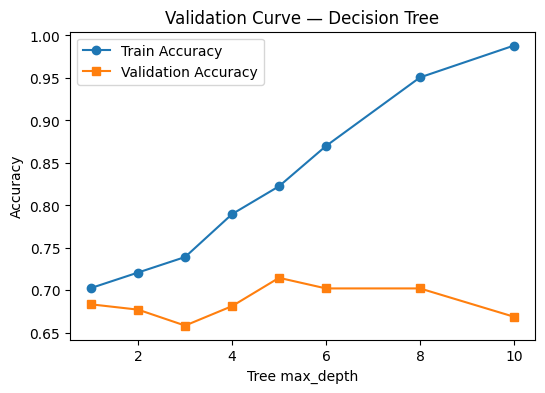

In [22]:

# --- 3.6 Validation Curve: Decision Tree max_depth ---

depth_range = [1, 2, 3, 4, 5, 6, 8, 10]

train_scores, val_scores = validation_curve(
    estimator=Pipeline([('pre', pre), ('model', DecisionTreeClassifier(random_state=1955))]),
    X=Xtr, y=ytr,
    param_name="model__max_depth",
    param_range=depth_range,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(depth_range, train_mean, marker="o", label="Train Accuracy")
plt.plot(depth_range, val_mean, marker="s", label="Validation Accuracy")
plt.xlabel("Tree max_depth")
plt.ylabel("Accuracy")
plt.title("Validation Curve — Decision Tree")
plt.legend()
plt.show()


### Validation Curve — Decision Tree (Effect of max_depth)

The `max_depth` parameter controls how many levels the tree can grow.
This directly affects model complexity:

- **Shallow trees** → simple rules → high bias  
- **Deep trees** → complex rules → high variance  

The validation curve shows how accuracy changes across depths from 1 to 10.

---

### What the curve shows?

#### 1. **Depth 1–3 → Underfitting**
- Training accuracy is low (0.70 → 0.74)  
- Validation accuracy is also low (0.68 → 0.66)  
- A shallow tree lacks the capacity to model nonlinear patterns  
**→ High bias**

#### 2. **Depth 4–6 → Best generalization**
- Training accuracy grows steadily (0.79 → 0.87)  
- Validation accuracy **peaks around depth = 5** (~0.72)  
- This depth provides the best balance between:
  - learning important relationships  
  - avoiding noise  
**→ Optimal model complexity**

#### 3. **Depth 7–10 → Overfitting**
- Training accuracy becomes extremely high (0.95 → 0.99)  
- Validation accuracy declines back to ~0.66  
- The tree memorizes training data  
- But performs worse on unseen patients  
**→ High variance**

---

### What this means for tuning?

The ideal depth depends on the dataset, but in this case:

- Depth **≈ 5** gives the strongest validation accuracy  
- Deeper trees (8+) are *too flexible*  
- Very shallow trees (1–3) are *too simplistic*

This is the classical **bias–variance tradeoff**:
- Too simple → fail to capture patterns  
- Too complex → memorize noise  
- Just right → best generalization  

---

### Why this prepares us for ensembles?

Because a single tree is so sensitive to depth:

- **Random Forests** reduce variance by averaging many trees  
- **Gradient Boosting** reduces bias by sequentially improving trees  

This explains why ensembles performed much better in Section 3.4.


In [23]:

# --- 3.6 GridSearchCV: Logistic Regression C ---

grid_C = {"model__C": np.logspace(-3, 3, 10)}

gs_log = GridSearchCV(
    estimator=log_reg,
    param_grid=grid_C,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gs_log.fit(Xtr, ytr)

print("Best C:", gs_log.best_params_['model__C'])
print("Best CV Accuracy:", gs_log.best_score_)

best_log = gs_log.best_estimator_
print("Test Accuracy:", best_log.score(Xte, yte))


Best C: 0.1
Best CV Accuracy: 0.7541666666666667
Test Accuracy: 0.7416666666666667


### Logistic Regression — Hyperparameter Tuning with GridSearchCV

GridSearchCV tests multiple values of **C** (the inverse of regularization strength)
and selects the one that gives the best cross-validation accuracy.

Here are the tuning results:

- **Best C:** 0.1  
- **Best CV Accuracy:** 0.754  
- **Test Accuracy:** 0.742  

---

### Interpretation

#### C = 0.1 is the optimal choice  
This matches what we saw in the validation curve:

- Very small C (strong regularization) underfits  
- Very large C (weak regularization) overfits  
- **C around 0.1–1 gives the best generalization**

GridSearchCV confirmed that **C = 0.1** provides the strongest performance.

#### CV Accuracy (0.754) > Test Accuracy (0.742)  
This is normal:

- Cross-validation uses five different splits  
- The test set is a single held-out fold  
- Slight differences simply reflect sampling variability

#### Regularization matters  
The optimal C is not too small or too large — a moderate amount of regularization is needed to prevent both underfitting and overfitting.

---

### Key Takeaway

Logistic Regression’s performance depends heavily on C:

- **Too much regularization** (C too small) → high bias  
- **Too little regularization** (C too large) → high variance  
- **C ≈ 0.1** strikes the best balance  

GridSearchCV confirms what the validation curve suggested and helps select the most reliable model for deployment.


In [24]:

# --- 3.6 GridSearchCV: Decision Tree max_depth ---

param_depth = {"model__max_depth": [1, 2, 3, 4, 5, 6, 8, 10]}

gs_tree = GridSearchCV(
    estimator=Pipeline([('pre', pre), ('model', DecisionTreeClassifier(random_state=1955))]),
    param_grid=param_depth,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gs_tree.fit(Xtr, ytr)

print("Best max_depth:", gs_tree.best_params_['model__max_depth'])
print("Best CV Accuracy:", gs_tree.best_score_)

best_tree = gs_tree.best_estimator_
print("Test Accuracy:", best_tree.score(Xte, yte))


Best max_depth: 5
Best CV Accuracy: 0.7145833333333333
Test Accuracy: 0.7333333333333333


### Decision Tree — Hyperparameter Tuning with GridSearchCV

GridSearchCV evaluated several values of `max_depth` to find the depth that provides the
best cross-validation accuracy and generalizes well.

**Results:**

- **Best max_depth:** 5  
- **Best CV Accuracy:** 0.715  
- **Test Accuracy:** 0.733  

---

### Interpretation

#### Best depth = 5  
This exactly matches what we saw in the validation curve:

- Depths 1–3 underfit (low accuracy)
- Depths 7–10 overfit (high training accuracy but poor validation accuracy)
- **Depth 5 consistently achieved the best validation performance**

GridSearchCV confirms that **max_depth = 5** balances complexity and generalization.

#### CV accuracy (0.715) vs test accuracy (0.733)
It’s normal for the test accuracy to be slightly higher or lower than the CV score:

- Cross-validation averages over 5 folds  
- The test set is a single held-out fold  
- Small fluctuations reflect natural sampling differences  

The key point is that depth 5 performs well consistently.

#### Why depth 5 works so well? 
At this depth, the tree:

- Captures important nonlinear interactions (cholesterol, age, rest_bp, max_hr)  
- Avoids memorizing noise  
- Produces a structure with interpretable splits  
- Achieves better generalization than deeper trees  

---

### Key Takeaways

The decision tree is *highly sensitive* to its depth:

- **Too shallow (1–3)** → underfitting  
- **Too deep (7–10)** → overfitting  
- **Just right (≈5)** → strongest predictive performance  

This tuning result reinforces why the next step — **ensemble methods (Random Forest, Gradient Boosting)** — is so important:

> Single trees are unstable and require careful tuning.  
> Ensembles naturally stabilize and improve on tree predictions.


## This is for teaching or debate. Not necessary
### Interpretation Notes (to fill after running Section 3.6)

- In the logistic regression validation curve:
  - Why does accuracy drop for very small C?
  - Why might accuracy drop for very large C?
- In the decision tree validation curve:
  - Which depth leads to overfitting?
  - Which depth appears to generalize best?
- Compare GridSearchCV’s selected hyperparameters to the validation curve insights.
- Discuss the trade-offs between:
  - Underfitting vs Overfitting  
  - Simplicity vs Complexity  
  - Accuracy vs Interpretability  

---
